In [ ]:
# import pandas as pd

# # 读取csv
# df = pd.read_csv("pending_alphas/pending_simulated_fnd6_ratioRank.csv")

# # 打乱数据
# df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
# df_shuffled = df_shuffled.sample(frac=1, random_state=42).reset_index(drop=True)
# # 保存为新的csv
# df_shuffled.to_csv("pending_alphas/pending_simulated_fnd6_ratioRank_shuffled.csv", index=False)


: 

In [ ]:
import re
import matplotlib.pyplot as plt
import matplotlib
import datetime

# 设置中文字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 中文黑体
matplotlib.rcParams['axes.unicode_minus'] = False    # 负号正常显示

# 日志文件路径
log_file = "logs/simulation_2025-09-09.log"

# 匹配完成alpha的日志行
pattern = re.compile(r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}).*ended with status:", re.IGNORECASE)

timestamps = []

# 读取日志并提取完成时间
with open(log_file, "r", encoding="utf-8") as f:
    for line in f:
        match = pattern.search(line)
        if match:
            time_str = match.group(1)
            timestamps.append(datetime.datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S"))

# 如果没有数据
if not timestamps:
    print("没有找到完成alpha的记录,请检查日志格式。")
    exit()

# 排序时间戳
timestamps.sort()

# 构建完成数量序列
counts = list(range(1, len(timestamps) + 1))

plt.figure(figsize=(12, 6))
plt.plot(timestamps, counts, marker="o", linestyle="-", color="blue")
plt.xlabel("时间")
plt.ylabel("完成 Alpha 数量")
plt.title("Alpha 完成进度")
plt.grid(True)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# ====== 平均速率 ======
total_time = (timestamps[-1] - timestamps[0]).total_seconds() / 3600  # 小时
total_alphas = len(timestamps)
avg_rate = total_alphas / total_time if total_time > 0 else 0

expected_counts = [
    avg_rate * ((t - timestamps[0]).total_seconds() / 3600)
    for t in timestamps
]

plt.figure(figsize=(12, 6))
plt.plot(timestamps, expected_counts, linestyle="--", color="red")
plt.xlabel("时间")
plt.ylabel("完成 Alpha 数量（平均速率拟合）")
plt.title(f"Alpha 平均完成速率：{avg_rate:.2f} 个/小时")
plt.grid(True)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

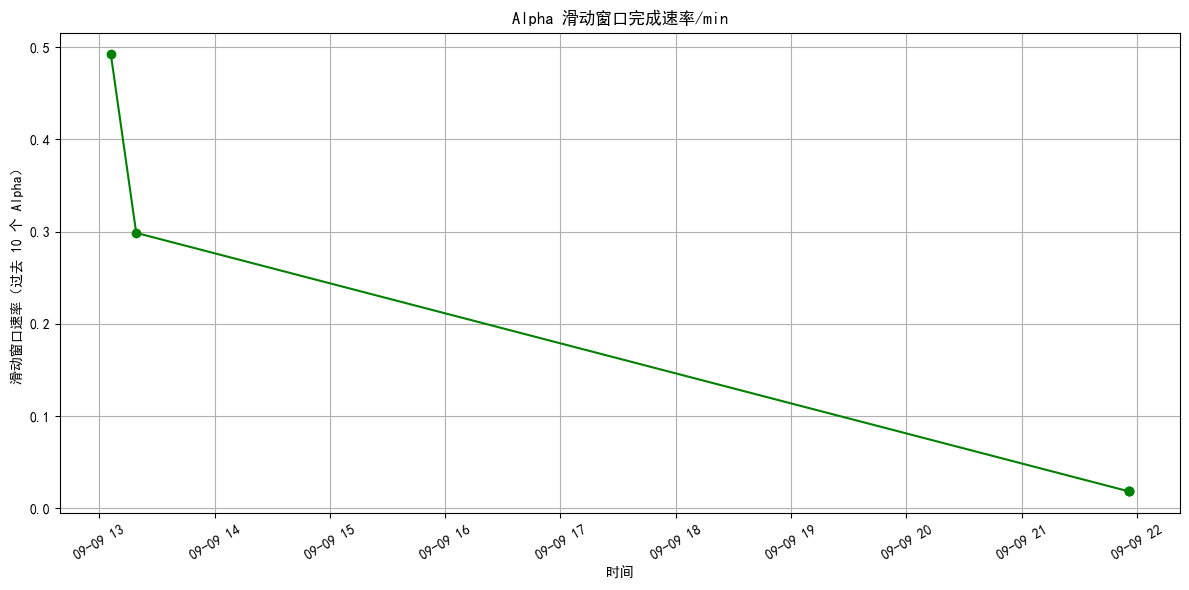

In [1]:
import re
import matplotlib.pyplot as plt
import matplotlib
import datetime

# 设置中文字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 中文黑体
matplotlib.rcParams['axes.unicode_minus'] = False    # 负号正常显示

# 日志文件路径
log_file = "logs/simulation_2025-09-09.log"

# 匹配完成alpha的日志行
pattern = re.compile(r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}).*ended with status:", re.IGNORECASE)

timestamps = []

# 读取日志并提取完成时间
with open(log_file, "r", encoding="utf-8") as f:
    for line in f:
        match = pattern.search(line)
        if match:
            time_str = match.group(1)
            timestamps.append(datetime.datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S"))

# 如果没有数据
if not timestamps:
    print("没有找到完成alpha的记录,请检查日志格式。")
    exit()

# 排序时间戳
timestamps.sort()

# ====== 滑动窗口速率 ======
window_size = 10  # 最近10个完成alpha
sliding_rates = []
sliding_times = []

for i in range(len(timestamps)):
    if i < window_size - 1:
        sliding_rates.append(None)  # 前几个无法计算完整窗口
        sliding_times.append(timestamps[i])
    else:
        delta_hours = (timestamps[i] - timestamps[i - window_size + 1]).total_seconds() / 60
        rate = window_size / delta_hours if delta_hours > 0 else 0
        sliding_rates.append(rate)
        sliding_times.append(timestamps[i])

plt.figure(figsize=(12, 6))
plt.plot(sliding_times, sliding_rates, linestyle="-", color="green", marker="o")
plt.xlabel("时间")
plt.ylabel(f"滑动窗口速率（过去 {window_size} 个 Alpha）")
plt.title("Alpha 滑动窗口完成速率/min")
plt.grid(True)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [2]:
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# 修改为你的日志文件路径
log_file = "logs/simulation_2025-09-09.log"

# 正则匹配
start_pattern = re.compile(r"^(.*?) - INFO - Strating simulation for alpha: (.*?) with settings")
end_pattern = re.compile(r"^(.*?) - INFO - Alpha id: (.*?) ended with status")

# 存储
pending = []   # 保存未结束的 simulation
finished = []  # 保存已完成的 simulation

with open(log_file, "r", encoding="utf-8") as f:
    for line in f:
        # 匹配开始
        m_start = start_pattern.search(line)
        if m_start:
            ts = datetime.strptime(m_start.group(1), "%Y-%m-%d %H:%M:%S")
            expr = m_start.group(2)
            pending.append({
                "start_time": ts,
                "expression": expr
            })
            continue
        
        # 匹配结束
        m_end = end_pattern.search(line)
        if m_end and pending:
            ts = datetime.strptime(m_end.group(1), "%Y-%m-%d %H:%M:%S")
            alpha_id = m_end.group(2)
            # 取最早的 pending
            task = pending.pop(0)
            task["end_time"] = ts
            task["alpha_id"] = alpha_id
            task["duration"] = (task["end_time"] - task["start_time"]).total_seconds()
            finished.append(task)

# 输出结果
import pandas as pd
df = pd.DataFrame(finished)
print(df)

# 保存为 CSV
# df.to_csv("alpha_log_summary.csv", index=False)


            start_time                                         expression  \
0  2025-09-09 12:45:46  group_rank(debt/fnd6_newqv1300_esoprq, subindu...   
1  2025-09-09 12:45:50  group_rank(fnd6_newqv1300_cshprq/fnd6_newqv130...   
2  2025-09-09 12:47:14  group_rank(fnd6_cptmfmq_atq/fnd6_newqv1300_txp...   
3  2025-09-09 12:48:46     group_rank(fnd6_ciother/fnd6_cik, subindustry)   
4  2025-09-09 12:50:54      group_rank(fnd6_txdba/fnd6_mrc3, subindustry)   
5  2025-09-09 12:52:27       group_rank(fnd6_acdo/fnd6_fiao, subindustry)   
6  2025-09-09 12:53:48  group_rank(fnd6_newqv1300_lqpl1q/fnd6_optlife,...   
7  2025-09-09 12:54:07  group_rank(fnd6_newqv1300_icaptq/debt_st, subi...   
8  2025-09-09 12:55:40    group_rank(fnd6_mkvaltq/fnd6_cld5, subindustry)   
9  2025-09-09 12:58:02  group_rank(fnd6_mrc5/fnd6_newqv1300_cimiiq, su...   
10 2025-09-09 12:59:25  group_rank(fnd6_mfma1_apalch/fnd6_mibt, subind...   
11 2025-09-09 13:03:05  group_rank(fnd6_newqv1300_lnoq/fnd6_cptnewqv13...   

In [3]:
len(df[df["duration"]>100])/len(df)

0.9166666666666666

In [4]:
df["duration"].describe()

count       12.000000
mean      8368.166667
std      14341.428976
min         88.000000
25%        306.250000
50%        336.000000
75%       9054.000000
max      32271.000000
Name: duration, dtype: float64